In [192]:
import numpy as np
import LoadData as ld
import LuminosityOptimization as lo
import matplotlib.pyplot as plt
from lmfit import Model
import scipy.optimize
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import time as t

#_____________________________________________
plt.close("all")

#Font setting
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
  "font.size": 12
})

Selecting the Year and the Fills 

In [193]:
#defining the start time of the program
start=t.time()

#Selecting Current Year
#years = [16, 17, 18]
year=16

#plotting
plot=True

#model parameters 
if year==16:
   n_i, k_b, B_s, E_s, B_r, G_r, S_int, n_c, N_i, T_hc, T_ph, S_z, S_s, Fe, f_rev, Xi, Eps= lo.Parameters2016()

elif year==17:
    n_i, k_b, B_s, E_s, B_r, G_r, S_int, n_c, N_i, T_hc, T_ph, S_z, S_s, Fe, f_rev, Xi, Eps= lo.Parameters2017()

elif year==18:
    n_i, k_b, B_s, E_s, B_r, G_r, S_int, n_c, N_i, T_hc, T_ph, S_z, S_s, Fe, f_rev, Xi, Eps= lo.Parameters2018()


#loading fill number
FillNumber16, FillNumber17, FillNumber18 = ld.FillNumber()

if year==16:
        FillNumber=FillNumber16

elif year==17:
    FillNumber=FillNumber17
    FillNumber_Prev=FillNumber16
    previous_year=16
elif year==18:
    FillNumber=FillNumber18
    FillNumber_Prev=FillNumber17
    previous_year=17
#print(FillNumber)

#Fill to delete [6638,6666,6174,7061,7065,7087,7124,7127]
skip16=[5097,5112,5117,5264,5406,5427,5439]
skip17=[5837,5840,6019,6055,6060,6082,6084,6089,6104,6106,6110,6116,6142,6143,6152,6156,6158,6160,6167,6168,6169,6193,6258,6268,6271,6272,6275,6283,6285,6287,6288,6291,6298,6303,6304,6305,6308,6311,6312,6314,6317,6324,6325,6337,6346,6356,6360,6362,6364,6371]
skip18=[6654,6659,6666,6688,6690,6694,6696,6706,6729,6741,6747,6752,6782,6778,6882,6890,6892,6901,6929,6939,6961,7036,7039,7118,7120,7135,7145,7217,7245,7259,7271,7324]
skip = skip16 + skip17 + skip18

for fill in skip:
    FillNumber=np.delete(FillNumber, (np.where(FillNumber==(fill))[0]))
for i in range(len(FillNumber)):
    if FillNumber[i] in skip:
        continue

Defining the Double Exponential fit function

In [194]:
def fit(x, a, b, c, d):
    return (a*np.exp((-b)*x))+(c*np.exp((-d)*x))

model=Model(fit)

In [195]:
# DEFINE THE FUNCTION FOR DATA SELECTION IN TIME SCALE

def Cut_Fit(year, text):
    """Function that performs the necessary cut on the current fill

    Args:
        year (int): current year
        text (str): current fill

    Returns:
        L_fit: cutted data
        T_fit_real: times in second for the cutted data fit
        Y: Luminosity evolution form the fit
        a: fitting parameter
        b: fitting parameter
        c: fitting parameter
        d: fitting parameter
        chi: reduced chi square of the fit
        L_evol: raw luminosity data
        Times: raw Unix time
    """
    year=str(year)
    f=open('ATLAS/ATLAS_fill_20{}/{}_lumi_ATLAS.txt'.format(year, text),"r")
    lines=f.readlines()
    L_evolx=[]
    times=[]
    for x in lines:
        times.append(int(x.split(' ')[0]))  
        L_evolx.append(float(x.split(' ')[2]))
        
    f.close()
    Times = np.array(times)
    L_evol = np.array(L_evolx)

    #deleting the null values of the luminosity
    zero=np.where(L_evol<100)
    L_zero=np.delete(L_evol, zero)
    T_zero=np.delete(Times, zero)
        
    #check for enough points
    if len(L_zero)<10:
        zero=np.where(L_evol<5)
        L_zero=np.delete(L_evol, zero)
        T_zero=np.delete(Times, zero)

    #defining the derivative 
    dy = np.zeros(L_zero.shape)
    dy[0:-1] = np.diff(L_zero)/np.diff(T_zero)


    #start to slim down the fit interval       
    L_tofit=[]
    T_tofit=[]
    for idx in range(len(L_zero)):
        #cancelling too strong derivative points
        if dy[idx]<0 and dy[idx]>-1.5:
            L_tofit.append(L_zero[idx])
            T_tofit.append(T_zero[idx])
        if dy[idx]>0 or dy[idx]<-1.5:
            continue     
        
    #evaluating the differences between two subsequent points
    diff=np.diff(L_tofit)
        
    #deleting the discrepancies
    thr=np.max(abs(diff))*0.05
    idx_diff= np.where(abs(diff)>thr)[0]+1
        
    #new slim down of data
    L_tofit2=np.delete(L_tofit, idx_diff)
    T_tofit2=np.delete(T_tofit, idx_diff)
        
    #check for enough points
    if len(L_tofit2) < 30:
        L_tofit2=L_tofit
        T_tofit2=T_tofit
        
    L_fit=L_tofit2
    T_fit=T_tofit2     

    L_fit=np.array(L_fit)
    T_fit=np.array(T_fit)

    #transforming the times from unix in seconds
    T_fit_real=T_fit-np.amin(T_fit)


    return T_fit_real,L_fit,L_evol, Times

In [196]:
#def PlotLumiTurn(Turn,L_norm,L_ma,LL, a, b, c, d,a_err,b_err, c_err,d_err,R_adjD,R_chiD,MSED, RMSED):
def PlotLumiTurn(Turn,L_norm,L_ma,LL, a, b, c, d,R_adjD,R_chiD,MSED, RMSED):
    """Function that plots all the needed graphs.

       Args:
           L_norm: Normlized Luminosity data 
           Turn: times in number of turns for the Normlized Luminosity data 
           L: Normlized Luminosity evolution form the fit
           a,b,c,d: fitting parameter from the double-exponential model
           a_err,b_err, c_err,d_err: the std on fitting parameter
           R_adj, R_chi: Adjusted R-square and Reduced Chi-square of the fit
           MSE, RMSE: Mean Squared Error and Root Mean Squared Error
            """

    print('Now lets plot our Models')
    print(FillNumber[i]) 
    
    #Mod2
    #Original and filtred data with Model2-DA Fit
    fig, ax= plt.subplots(num=1, clear=True)
    ax.plot(Turn/1e9, L_norm, "b.", markersize=4, label='Data') #The normlized luminosity
    ax.plot(Turn/1e9, LL , 'r-', label='Double-Exp Fit') #The Double exponential model fit
    ax.set_title('FillNumber: {}'.format(text))
    ax.set_xlabel(' Time in Number of Turns 'r'$\tau$(10$^9$)')
    ax.set_ylabel('${L}/{L_i}$' ) 
    plt.legend(loc='best')
    plt.savefig('DOUBLE/20{}/Fit/{}_Fit_mod2.pdf'.format(str(year),text))
    #plt.show()

Fit the Double-Exponential Model to the nomalized luminosity 

In [197]:
# HERE WE STORE DATA PARAMETERS AND FIT OUTPUTS

with open('DOUBLE/20{}/Coeff/Double_Coeff_20{}.txt'.format(str(year),str(year)), 'w') as f:
    f.write('')
    f.close()   

with open('DOUBLE/20{}/Coeff/Double_Rajd_20{}.txt'.format(str(year),str(year)), 'w') as f:
    f.write('')
    f.close()

with open('DOUBLE/20{}/Coeff/Double_MSE_20{}.txt'.format(str(year),str(year)), 'w') as f: 
    f.write('')
    f.close()

with open('DOUBLE/initial/20{}_Initial_Max_LumTurn.txt'.format(str(year)), 'w') as f:
    f.write('')
    f.close()

Now lets plot our Models
5017.0
Now lets plot our Models
5020.0
Now lets plot our Models
5043.0
Now lets plot our Models
5045.0
Now lets plot our Models
5069.0
Now lets plot our Models
5073.0
Now lets plot our Models
5076.0
Now lets plot our Models
5078.0
Now lets plot our Models
5080.0
Now lets plot our Models
5085.0
Now lets plot our Models
5093.0
Now lets plot our Models
5095.0
Now lets plot our Models
5096.0
Now lets plot our Models
5102.0
Now lets plot our Models
5105.0
Now lets plot our Models
5106.0
Now lets plot our Models
5109.0
Now lets plot our Models
5111.0
Now lets plot our Models
5116.0
Now lets plot our Models
5163.0
Now lets plot our Models
5173.0
Now lets plot our Models
5181.0
Now lets plot our Models
5199.0
Now lets plot our Models
5205.0
Now lets plot our Models
5253.0
Now lets plot our Models
5257.0
Now lets plot our Models
5258.0
Now lets plot our Models
5261.0
Now lets plot our Models
5277.0
Now lets plot our Models
5282.0
Now lets plot our Models
5339.0
Now lets

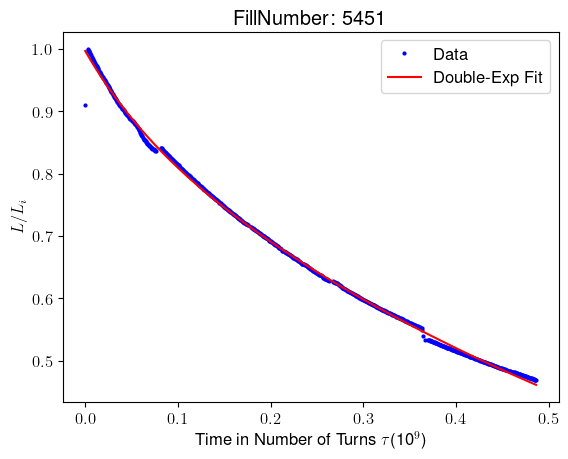

In [198]:
# WE WORK WITH NUMBER OF TURNS INSTEAD OF TIME SCALE AND THE LUMINOSITY IS NORMLISED 

for i in range(len(FillNumber)):
    text = str(int(FillNumber[i])) #number of current fill
    # DATA LOADING
    T_fit_real,L_fit,L_evol, Times= Cut_Fit(year, text)

    #defining the new time variable representing the number of turns
    Turn=[] 
    Turn=np.array(Turn)
    for el in T_fit_real:
        tau=(f_rev*el+1)
        Turn=np.append(Turn, tau)

    L_min = min(L_fit)
    L_max = max(L_fit)
    #
    # Normlise L_fit
    L_Tau = L_fit/L_max 

    L_ma = np.array(L_max)
    L_norm = np.array(L_Tau)
    
    # FIRST NORMLIZE THE NUMBER OF TURNS
    Tau_norm = (Turn)/(np.max(Turn))
    Tau_norm = np.array(Tau_norm)
    
    # START WITH FITTING THE Double-Exponential MODEL
    #params, pcov = curve_fit(fit, Tau_norm, L_norm,bounds=(0, [1,1000,1,1000]),maxfev=5000)
    
    """if year==16:
        #p0 = (1,1,1,1) 
        params, pcov = curve_fit(fit, Tau_norm, L_norm,bounds=(0, [1,10,1,10]),maxfev=5000)
    elif year==17:
        #p0 = (1,1,1,1) 
        params, pcov = curve_fit(fit, Tau_norm, L_norm,bounds=(0, [1,100,1,100]),maxfev=5000)
    elif year==18:
        #p0 = (1,1,1,1) 
        params, pcov = curve_fit(fit, Tau_norm, L_norm,bounds=(0, [1,100,1,100]),maxfev=5000)
        
    a, b, c, d = params
    perr = np.sqrt(np.diag(pcov))
    a_err,b_err, c_err,d_err = perr
    """
    #performing fit 
    model.set_param_hint('b', value=0.1, min=0, max=100)
    model.set_param_hint('d', value=0.1, min=0, max=100)
    model.set_param_hint('a', value=0.1, min=0, max=1)
    model.set_param_hint('c', value=0.1, min=0, max=1)
    fit_result=model.fit(L_norm, x=Tau_norm, a=0.1, b=0.1, c=0.1, d=0.1)
    
    LL=fit(Turn, fit_result.params['a'].value, (fit_result.params['b'].value/(np.amax(Turn))), fit_result.params['c'].value, fit_result.params['d'].value/(np.amax(Turn)))
    a = fit_result.params['a'].value
    b= fit_result.params['b'].value/(np.amax(Turn))
    #b= fit_result.params['b'].value
    c = fit_result.params['c'].value
    d = fit_result.params['d'].value/(np.amax(Turn))
    #d= fit_result.params['d'].value

    #LL = fit(Turn, a, b/(np.max(Turn)),c, d/(np.max(Turn)))

    # RESIDUALS 
    AbsErr = L_norm - LL
    #print('absErr', AbsErr)
    SE = np.square(AbsErr) # squared errors
    MSED = np.mean(SE) # mean squared errors
    RMSED = np.sqrt(MSED) # Root Mean Squared Error, RMSE

    # calculate the R-squared value
    r_squared = r2_score(L_norm, LL)

    # number of observations
    n = len(L_norm)
    # number of predictors (not including the constant term)
    #p = len(params) - 1
    p = 4

    # calculate the adjusted R-squared value
    R_adjD = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    # calculate the chi_square value
    chi_square = sum(((L_norm - LL)/L_norm)**2)
    # calculate the Reduced_chi_square
    R_chiD = chi_square/(len(L_norm) - 3)

    if plot==True:
       #PlotLumiTurn(Turn,L_norm,L_ma,LL, a, b, c, d,a_err,b_err, c_err,d_err,R_adjD,R_chiD,MSED, RMSED)
       PlotLumiTurn(Turn,L_norm,L_ma,LL, a, b, c, d,R_adjD,R_chiD,MSED, RMSED)
        
    # CUTTED - INITIAL - NORMLISED : DATA STORAGE
    with open('DOUBLE/20{}/Data/{}.txt'.format(str(year),text), 'w') as f:
        f.write('')
        f.close()

    with open('DOUBLE/20{}/Data/{}_DoubleFit.txt'.format(str(year),text), 'w') as f:
        f.write('')
        f.close()
      
    for x in range(len(Turn)):
        with open('DOUBLE/20{}/Data/{}.txt'.format(str(year),text), 'a') as f:
            f.write(str(Turn[x]))
            f.write(' ')
            f.write(str(L_norm[x])) # Here Lumi_evol is the same as L_Tau since no extrapolation needed
            f.write('\n')
        with open('DOUBLE/20{}/Data/{}_DoubleFit.txt'.format(str(year),text), 'a') as f:
            f.write(str(Turn[x]))
            f.write(' ')
            f.write(str(LL[x])) 
            f.write('\n')

    # SAVING THE INITIAL LUMINOSITY VALUE:
    with open('DOUBLE/initial/20{}_Initial_Max_LumTurn.txt'.format(str(year)), 'a') as f:
        f.write(text)
        f.write(' ')
        f.write(str(L_ma))
        f.write('\n')
        
    # SAVING PARAMETERS OF LUMINOSITY EVOLUTION FROM FIT: 
    
        with open('DOUBLE/20{}/Coeff/Double_Coeff_20{}.txt'.format(str(year),str(year)), 'a') as f:
           f.write(text)
           f.write(' ')
           f.write(str(a))
           f.write(' ')
           f.write(str(b))
           f.write(' ')
           f.write(str(c))
           f.write(' ')
           f.write(str(d))
           f.write('\n')

        with open('DOUBLE/20{}/Coeff/Double_Rajd_20{}.txt'.format(str(year),str(year)), 'a') as f:
           f.write(text)
           f.write(' ')
           f.write(str(R_adjD))
           f.write(' ')
           f.write(str(R_chiD))
           f.write('\n')
 
        with open('DOUBLE/20{}/Coeff/Double_MSE_20{}.txt'.format(str(year),str(year)), 'a') as f:
           f.write(text)
           f.write(' ')
           f.write(str(RMSED))
           f.write(' ')
           f.write(str(MSED))
           f.write('\n') 

In [199]:
def PlotParam(a, b, c, d,R_adjD,R_chiD,MSED, RMSED):

   with open('DOUBLE/20{}/Coeff/Double_Coeff_20{}.txt'.format(str(year),str(year)), "r") as f:
      lines=f.readlines()
      fn=[] #fill number
      a=[]
      b=[]
      c=[]
      d=[]
      
      for x in lines:
         fn.append(float(x.split(' ')[0]))
         a.append(float(x.split(' ')[1]))
         b.append(float(x.split(' ')[2]))
         c.append(float(x.split(' ')[3]))  
         d.append(float(x.split(' ')[4]))
         
       
   fn = np.array(fn)
   a = np.array(a)
   b = np.array(b)
   c = np.array(c)
   d = np.array(d)
   
   fig, ax= plt.subplots()
   ax.hist(a, bins=20, density=True)
   #plt.axvline(a_weighted_average, color='m', linestyle='dashed', linewidth=2,label='Weighted Average: {:.4f}'.format(a_weighted_average))
   #plt.axvline(average_a, color='r', linestyle='dashed', linewidth=2,label='Average: {:.4f}'.format(average_a))
   #plt.legend("a","average_a")
   ax.set_title('$a$ Parameter 20{}'.format(str(year)))
   ax.set_xlabel('$a$ Parameter Values')
   ax.set_ylabel('Normalized Frequencies')
   #plt.legend(loc='best')
   plt.savefig('DOUBLE/20{}/Coeff/img/a_hist{}.pdf'.format(str(year),str(year)))
   
      
   fig1, ax1= plt.subplots()
   ax1.hist(b, bins=20, density=True)
   ax1.set_title('$b$ Parameter 20{}'.format(str(year)))
   ax1.set_xlabel('$b$ Parameter Values')
   ax1.set_ylabel('Normalized Frequencies')
   plt.savefig('DOUBLE/20{}/Coeff/img/b_hist{}.pdf'.format(str(year),str(year)))
   
   fig2, ax2= plt.subplots()
   ax2.hist(c, bins=20, density=True)
   ax2.set_title('$c$ Parameter 20{}'.format(str(year)))
   ax2.set_xlabel('$c$ Parameter Values')
   ax2.set_ylabel('Normalized Frequencies')
   plt.savefig('DOUBLE/20{}/Coeff/img/c_hist{}.pdf'.format(str(year),str(year)))
   
   fig3, ax3= plt.subplots()
   ax3.hist(d, bins=20, density=True)
   ax3.set_title('$d$ Parameter 20{}'.format(str(year)))
   ax3.set_xlabel('$d$ Parameter Values')
   ax3.set_ylabel('Normalized Frequencies')
   plt.savefig('DOUBLE/20{}/Coeff/img/d_hist{}.pdf'.format(str(year),str(year)))
   
   fig4, ax4= plt.subplots(num=1, clear=True)
   ax4.plot(a, b, "b.")
   ax4.set_title('Correlation between $a$ and $b$ 20{}'.format(str(year)))
   ax4.set_xlabel('$a$')
   ax4.set_ylabel('$b$')
   plt.savefig('DOUBLE/20{}/Coeff/img/a_corr_b{}.pdf'.format(str(year),str(year)))
   
   fig5, ax5= plt.subplots(num=1, clear=True)
   ax5.plot(c, d, "b.")
   ax5.set_title('Correlation between $c$ and $d$ 20{}'.format(str(year)))
   ax5.set_xlabel('$c$')
   ax5.set_ylabel('$d$')
   plt.savefig('DOUBLE/20{}/Coeff/img/c_corr_d{}.pdf'.format(str(year),str(year)))
   
   fig6, ax6= plt.subplots(num=1, clear=True)
   ax6.plot(a, c, "b.")
   ax6.set_title('Correlation between $a$ and $c$ 20{}'.format(str(year)))
   ax6.set_xlabel('$a$')
   ax6.set_ylabel('$c$')
   plt.savefig('DOUBLE/20{}/Coeff/img/a_corr_c{}.pdf'.format(str(year),str(year)))
   
   fig7, ax7= plt.subplots(num=1, clear=True)
   ax7.plot(b, d, "b.")
   ax7.set_title('Correlation between $b$ and $d$ 20{}'.format(str(year)))
   ax7.set_xlabel('$b$')
   ax7.set_ylabel('$d$')
   plt.savefig('DOUBLE/20{}/Coeff/img/b_corr_d{}.pdf'.format(str(year),str(year)))
   
   fig8, ax8= plt.subplots(num=1, clear=True)
   ax8.plot(fn, a, "b.",label="k")
   ax8.set_title('$a$ Parameter 20{}'.format(str(year)))
   ax8.set_xlabel('Fills')
   ax8.set_ylabel('$a$')
   plt.savefig('DOUBLE/20{}/Coeff/img/a_doubExp{}.pdf'.format(str(year),str(year)))
   
   fig9, ax9= plt.subplots(num=1, clear=True)
   ax9.plot(fn, b, "b.",label="k")
   ax9.set_title('$b$ Parameter 20{}'.format(str(year)))
   ax9.set_xlabel('Fills')
   ax9.set_ylabel('$b$')
   plt.savefig('DOUBLE/20{}/Coeff/img/b_doubExp{}.pdf'.format(str(year),str(year)))
   
   fig10, ax10= plt.subplots(num=1, clear=True)
   ax10.plot(fn, c, "b.",label="k")
   ax10.set_title('$c$ Parameter 20{}'.format(str(year)))
   ax10.set_xlabel('Fills')
   ax10.set_ylabel('$c$')
   plt.savefig('DOUBLE/20{}/Coeff/img/c_doubExp{}.pdf'.format(str(year),str(year)))
   
   fig11, ax11= plt.subplots(num=1, clear=True)
   ax11.plot(fn, d, "b.",label="k")
   ax11.set_title('$d$ Parameter 20{}'.format(str(year)))
   ax11.set_xlabel('Fills')
   ax11.set_ylabel('$d$')
   plt.savefig('DOUBLE/20{}/Coeff/img/d_doubExp{}.pdf'.format(str(year),str(year)))
   
   with open('DOUBLE/20{}/Coeff/Double_Rajd_20{}.txt'.format(str(year),str(year)), "r") as f:
      lines=f.readlines()
      fn=[] #fill number
      Radj=[]
      RChi=[]

      for x in lines:
         fn.append(float(x.split(' ')[0]))
         Radj.append(float(x.split(' ')[1]))
         RChi.append(float(x.split(' ')[2]))
          
      fn = np.array(fn)
      Rs = np.array(Radj)
      chi = np.array(RChi)

      fig, ax= plt.subplots(num=1, clear=True)
      ax.plot(fn, Rs*100, "g.")
      ax.set_title('$Double$-$Exponential$ ${R_{adj}}$$^2$ 20%s' % str(year))
      ax.set_xlabel('Fill')
      ax.set_ylabel('${R_{adj}}$$^2${({\%})}')
      plt.savefig('DOUBLE/20{}/Coeff/img/Radj_doubExp{}.pdf'.format(str(year),str(year)))

      fig1, ax1= plt.subplots(num=1, clear=True)
      ax1.plot(fn, chi*100, "g.")
      ax1.set_title('$Double$-$Exponential$ ${\chi}^2$- 20%s' % str(year))
      ax1.set_xlabel('Fill')
      ax1.set_ylabel('${\chi}^2$''{\%}')
      plt.savefig('DOUBLE/20{}/Coeff/img/Chi_doubExp{}.pdf'.format(str(year),str(year)))         

      fig2, ax2= plt.subplots()
      #ax.plot(fn, b, "b.")
      ax2.hist(Rs*100, bins=20, density=True)
      ax2.set_title('$Double$-$Exponential$ ${R_{adj}}$$^2$ 20%s' % str(year))
      ax2.set_xlabel('${R_{adj}}$$^2${({\%})} Parameter Values')
      ax2.set_ylabel('Normalized Frequencies')
      plt.savefig('DOUBLE/20{}/Coeff/img/Radj_hist{}.pdf'.format(str(year),str(year)))
    
   with open('DOUBLE/20{}/Coeff/Double_MSE_20{}.txt'.format(str(year),str(year)), "r") as f:
      lines=f.readlines()
      fn=[] #fill number
      RMSE=[]
      MSE=[]  
      
      for x in lines:
         fn.append(float(x.split(' ')[0]))
         RMSE.append(float(x.split(' ')[1]))
         MSE.append(float(x.split(' ')[2]))
               
      fn = np.array(fn)
      Rms = np.array(RMSE)
      ms = np.array(MSE)
      
      fig1, ax1= plt.subplots(num=1, clear=True)
      ax1.plot(fn, Rms*100, "g.")
      ax1.set_title('$Double$-$Exponential$ $RMSE$- 20{}'.format(str(year)))
      ax1.set_xlabel('Fill')
      ax1.set_ylabel('$RMSE$''{\%}')
      plt.savefig('DOUBLE/20{}/Coeff/img/RMSE_doubExp{}.pdf'.format(str(year),str(year)))
      
      fig2, ax2= plt.subplots(num=1, clear=True)
      ax2.plot(fn, ms*100, "g.")
      ax2.set_title('$Double$-$Exponential$ $MSE$- 20{}'.format(str(year)))
      ax2.set_xlabel('Fill')
      ax2.set_ylabel('$MSE$''{\%}')
      plt.savefig('DOUBLE/20{}/Coeff/img/MSE_doubExp{}.pdf'.format(str(year),str(year)))
        

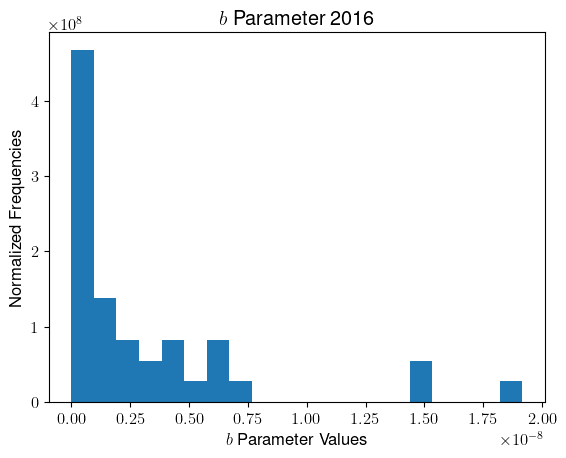

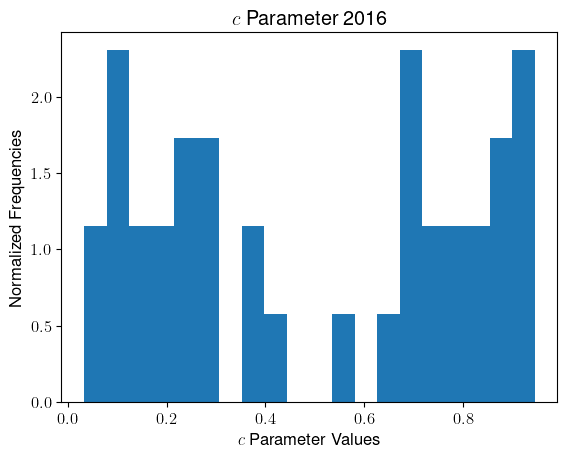

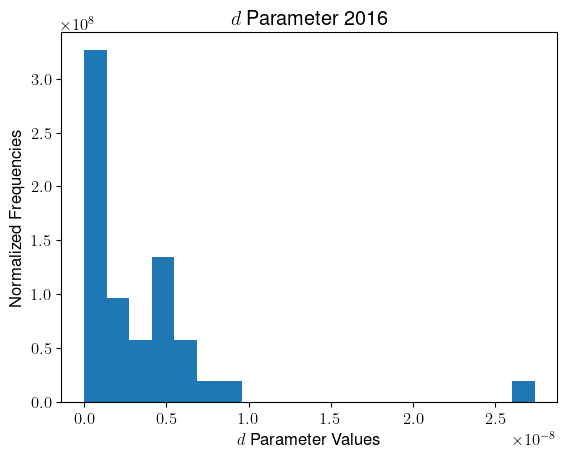

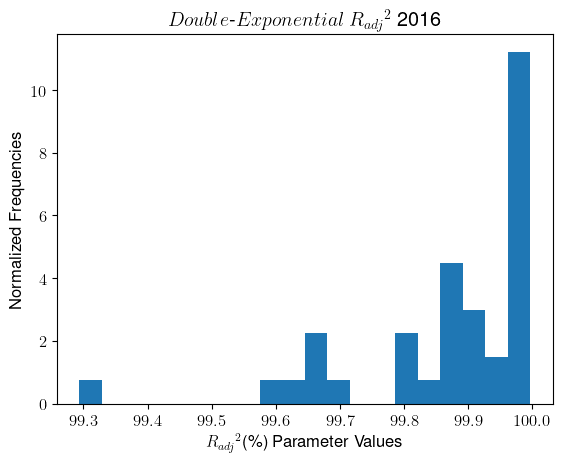

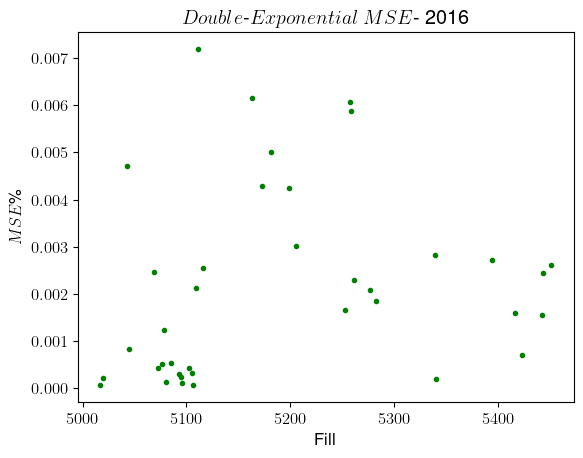

In [200]:
PlotParam(a, b, c, d,R_adjD,R_chiD,MSED, RMSED)

In [201]:
#defining the stop time of the program      
stop=t.time()
#evaluating the run time 
runtime_seq=stop-start
print('The runtime is:', runtime_seq, '[s]')

The runtime is: 125.34562611579895 [s]
